In [33]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.stats.proportion import proportion_confint

import utils

plt.style.use(
    [
        "tableau-colorblind10",
        utils.get_style("default"),
        utils.get_style("1-col"),
    ]
)

COLORS = plt.rcParams["axes.prop_cycle"].by_key()["color"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
def generate_fancy_plots(
    df: pd.DataFrame, 
    adv_name: str,
    highlighted_victim_steps = None,
    skip_legend: bool = False,
    custom_legend_label: str = "",
    custom_xlabel: str | None = None,
    custom_ylabel: str | None = None,
    vv_filter: list[int] | None = None,
    x_axis_column = "victim_steps",
):
    """Generate plot of adv win rate (y-axis) vs. victim training time (x-axis)."""
    
    ALPHA = 0.05
    for i, vv in enumerate(sorted(df.victim_visits.unique())):
        if vv_filter is not None and vv not in vv_filter:
            continue

        sub_df = df.query(
            "&".join(
                [
                    "victim_visits == @vv",
                    "adv_name == @adv_name",
                ]
            )
        )
        mean_df = sub_df.groupby(x_axis_column).adv_win.mean()

        (100 * mean_df).plot(
            label=(None if skip_legend else f"{custom_legend_label}{vv}"), 
            color=COLORS[i]
        )

        # Compute Clopper-Pearson confidence intervals
        ci_df = sub_df.groupby(x_axis_column).adv_win.apply(
            lambda x: proportion_confint(
                x.sum(),
                len(x),
                alpha=ALPHA,
                method="beta",
            )
        )
        ci_df = pd.DataFrame(
            ci_df.tolist(), index=ci_df.index, columns=["lower", "upper"]
        )
        ci_df = 100 * ci_df
        plt.fill_between(
            mean_df.index,
            ci_df.lower,  # type: ignore
            ci_df.upper,  # type: ignore
            alpha=0.3,
            color=COLORS[i],
            edgecolor="none",
        )

        if highlighted_victim_steps:
            highlighted_row = sub_df.query("victim_steps == @highlighted_victim_steps")
            plt.plot(
                highlighted_row[x_axis_column].mean(),
                100 * highlighted_row.adv_win.mean(),
                "D",
                color=COLORS[i],
                alpha=0.7,
            )
    # Legend in lower left corner
    if not skip_legend:
        plt.legend()
    plt.ylabel(
        custom_ylabel or r"Win rate \%"
    )
    plt.xlabel(custom_xlabel or rf"KataGo training steps")

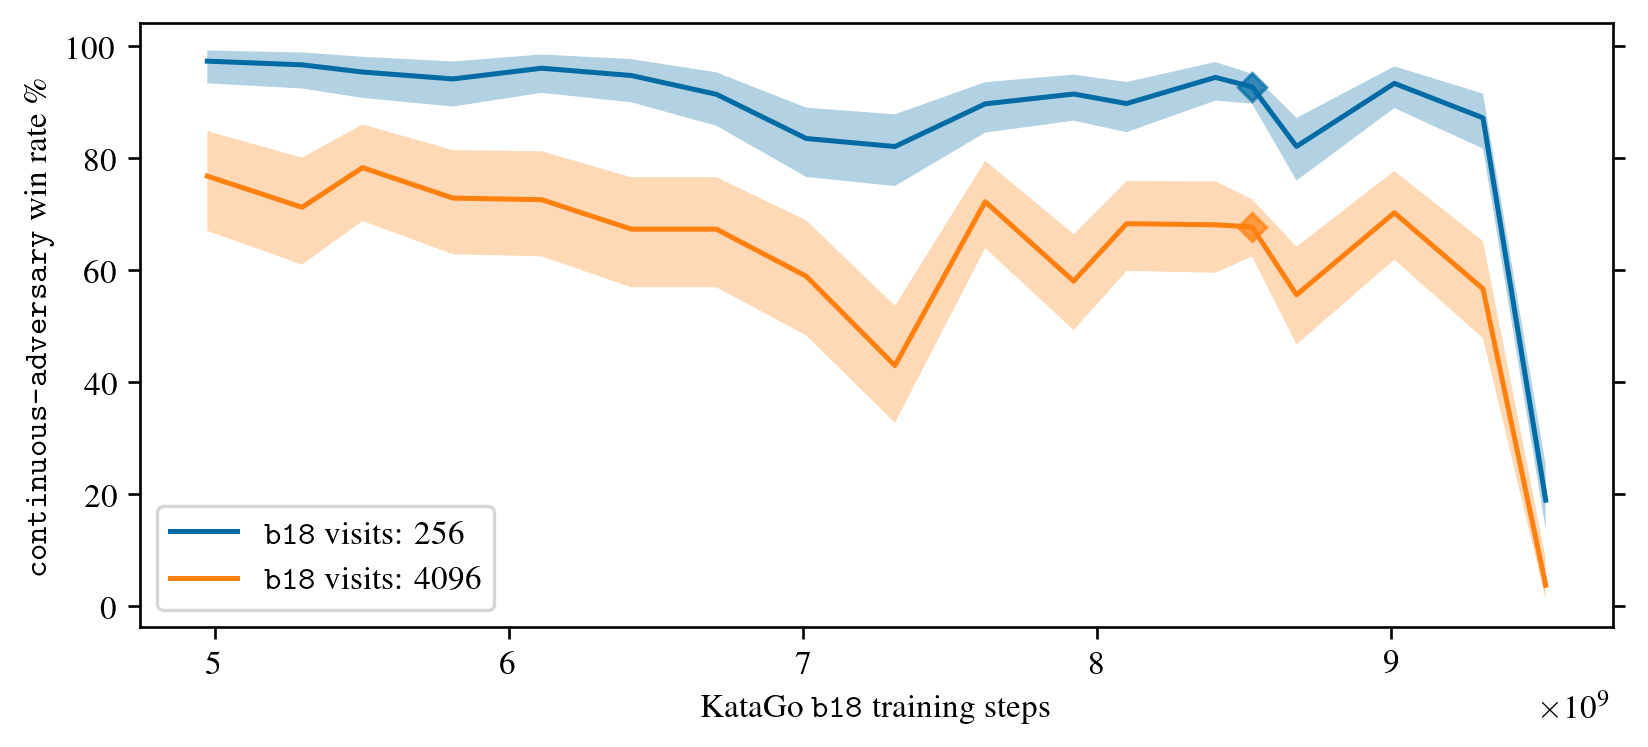

In [62]:
# TODO regen when cont sweeps finish
df = utils.parse_sgfs(["/shared/match/ttseng-cont-sweeps-240313/b18-ckpts"])
generate_fancy_plots(
    df, 
    adv_name="adv-s630461952-v600-AMCTS",
    highlighted_victim_steps=8526915840,
    custom_legend_label=r"\texttt{b18} visits: ",
    custom_xlabel=r"KataGo \texttt{b18} training steps",
    custom_ylabel=r"\texttt{continuous-adversary} win rate \%",
)

In [63]:
def swap_adv_and_victim(df: pd.DataFrame):
    to_swap = ["color", "name", "visits", "steps", "rsym", "algo"]
    for col in to_swap:
        col1 = f"victim_{col}"
        col2 = f"adv_{col}"
        df[col1], df[col2] = df[col2], df[col1]
    nums_to_negate = ["adv_komi", "adv_minus_victim_score", "adv_minus_victim_score_wo_komi"]
    for col in nums_to_negate:
        df[col] = -df[col]
    df["adv_win"] = ~df["adv_win"]

def cached_get_v100_gpu_days(
    training_path: Path,
) -> dict[int, float]:
    """Returns the estimated V100 GPU-days for each adv checkpoint."""
    selfplay_path = training_path / "selfplay"
    cache_file = selfplay_path / "steps_to_v100_gpu_days.log"
    if not cache_file.exists():
        raise RuntimeError(f"Run cached_get_v100_gpu_days() in robustness-estimate-gpu-days-adv.ipynb first to generate {cache_file}")
    with open(cache_file) as f:
        steps_to_gpu_days = json.load(f)
    return { int(steps): gpu_days for steps, gpu_days in steps_to_gpu_days.items()}

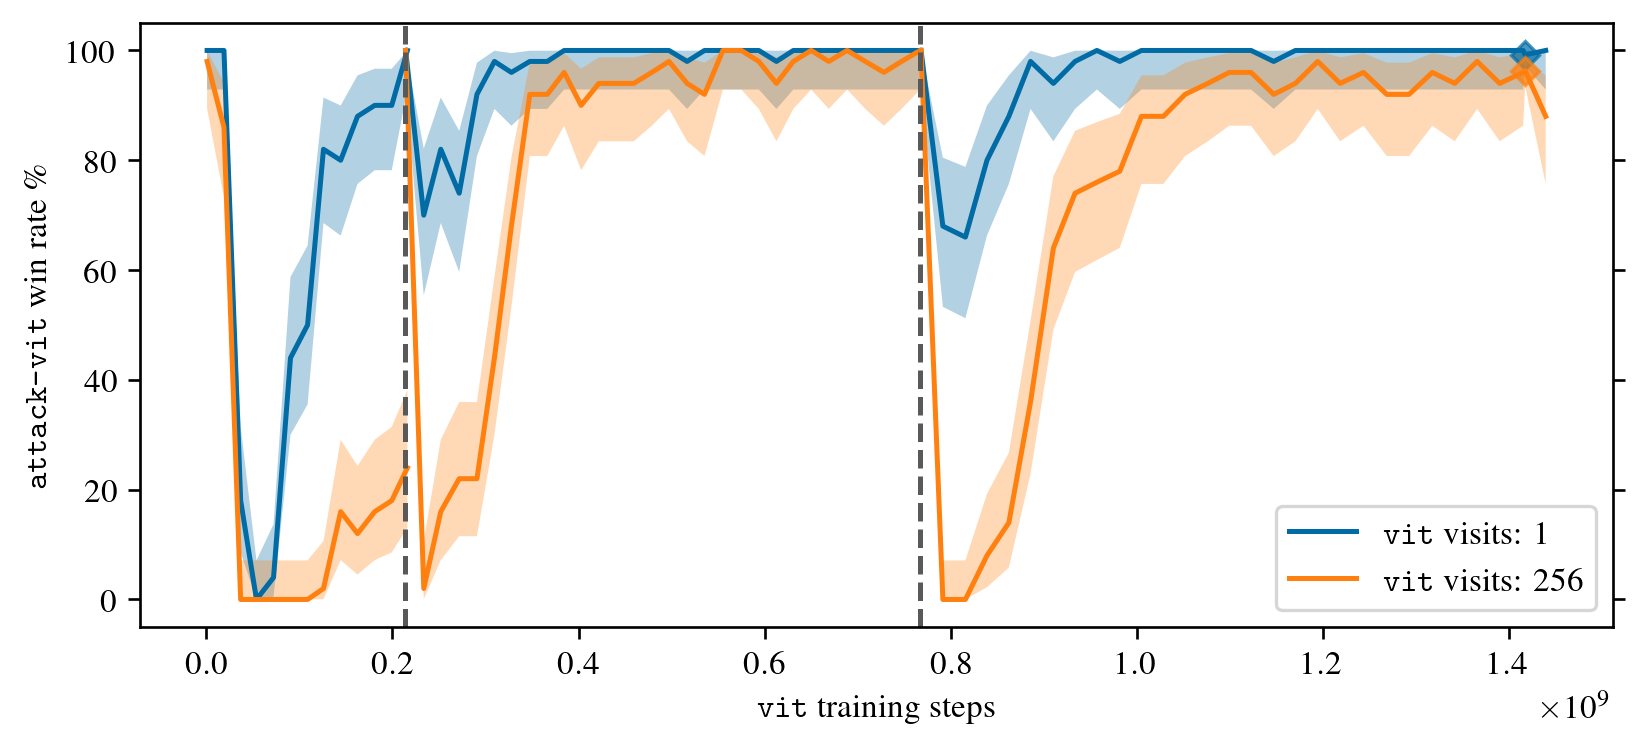

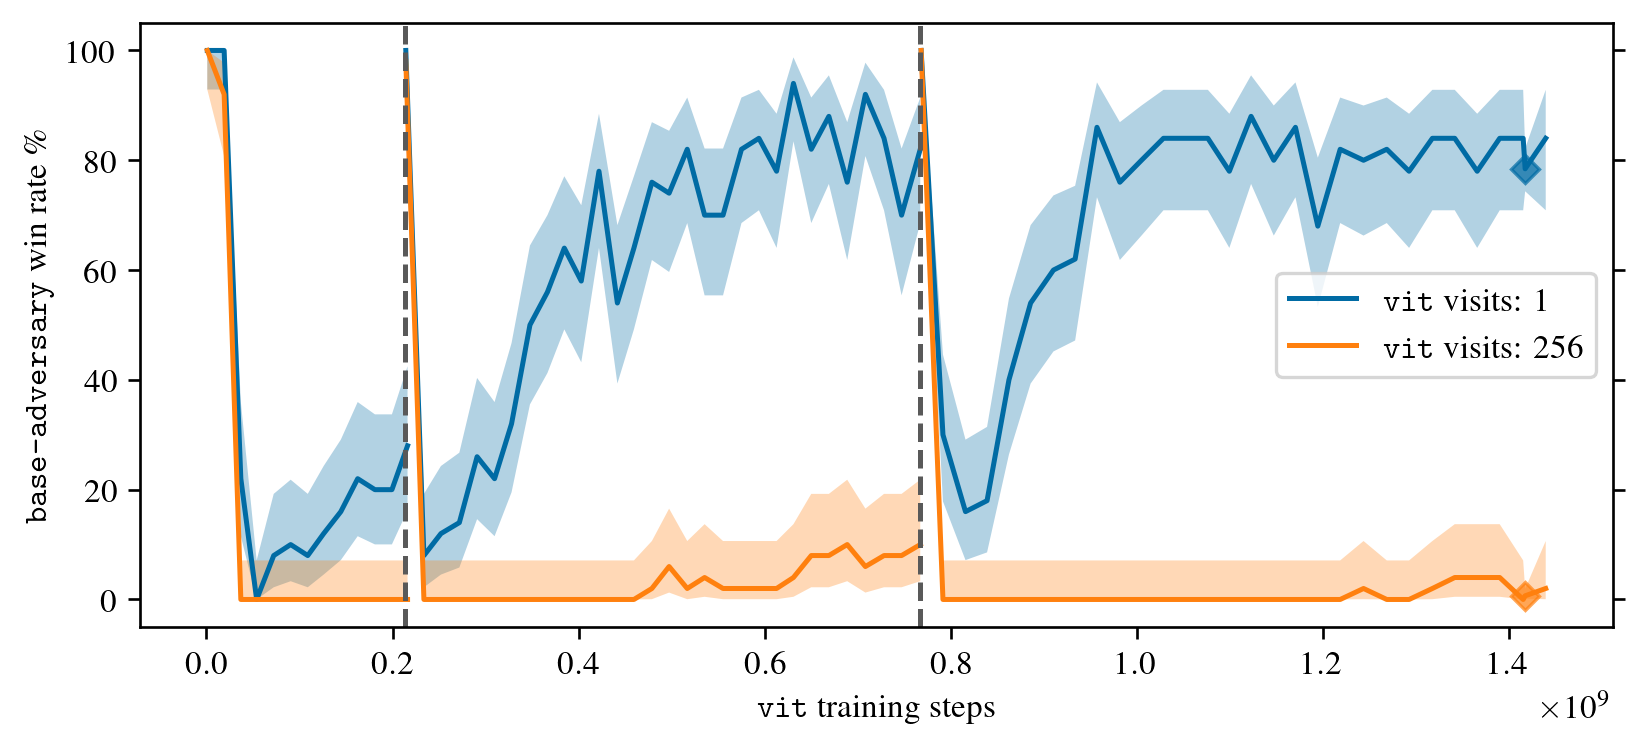

In [77]:
VIT_B4_MAX_STEPS = 213218816
VIT_B8_MAX_STEPS = 553885440
VIT_B16_MAX_STEPS = 650025472

df = utils.parse_sgfs(
    f"/shared/match/ttseng-vit-selfplay-240314/{name}"
    for name in ["vit-b4", "vit-b8", "vit-b16"]
)
# Adversaries and victims are swapped in these data, let's unswap everything
swap_adv_and_victim(df)

df["victim_architecture"] = df["sgf_path"].str.split("/").str[4]
df["original_victim_steps"] = df["victim_steps"]
# vit-b4 nets above s217m are bad. but we have one net slightly above VIT_B4_MAX_STEPS, 
# and below s217m, we'll include it in the plot because I forgot to eval VIT_B4_MAX_STEPS
df = df[(df["victim_architecture"] != "vit-b4") | (df["victim_steps"] <= 217500000)]
# Show vit-b4, vit-b8, and vit-b16 sequentially
df.loc[df["victim_architecture"] == "vit-b8", "victim_steps"] += VIT_B4_MAX_STEPS
df.loc[df["victim_architecture"] == "vit-b16", "victim_steps"] += VIT_B4_MAX_STEPS + VIT_B8_MAX_STEPS

for adv_name, adv_label in [
    ("attack-vit-s326m", r"\texttt{attack-vit}"),
    ("cyclic-s545m", r"\texttt{base-adversary}"),
]:
    # Plot different architectures separately so that their lines
    # aren't connected.
    for i, architecture in enumerate(["vit-b4", "vit-b8", "vit-b16"]):
        highlighted_steps = VIT_B4_MAX_STEPS + VIT_B8_MAX_STEPS + VIT_B16_MAX_STEPS if architecture == "vit-b16" else None
        generate_fancy_plots(
            df[df["victim_architecture"] == architecture], 
            adv_name=adv_name,
            highlighted_victim_steps=highlighted_steps,
            skip_legend=(i != 0),
            custom_legend_label=r"\texttt{vit} visits: ",
            custom_xlabel=r"\texttt{vit} training steps",
            custom_ylabel=f"{adv_label} win rate \%",
        )
    for step in [ VIT_B4_MAX_STEPS, VIT_B4_MAX_STEPS + VIT_B8_MAX_STEPS ]:
        plt.axvline(x=step, linestyle="--", color=COLORS[3])
    plt.show()

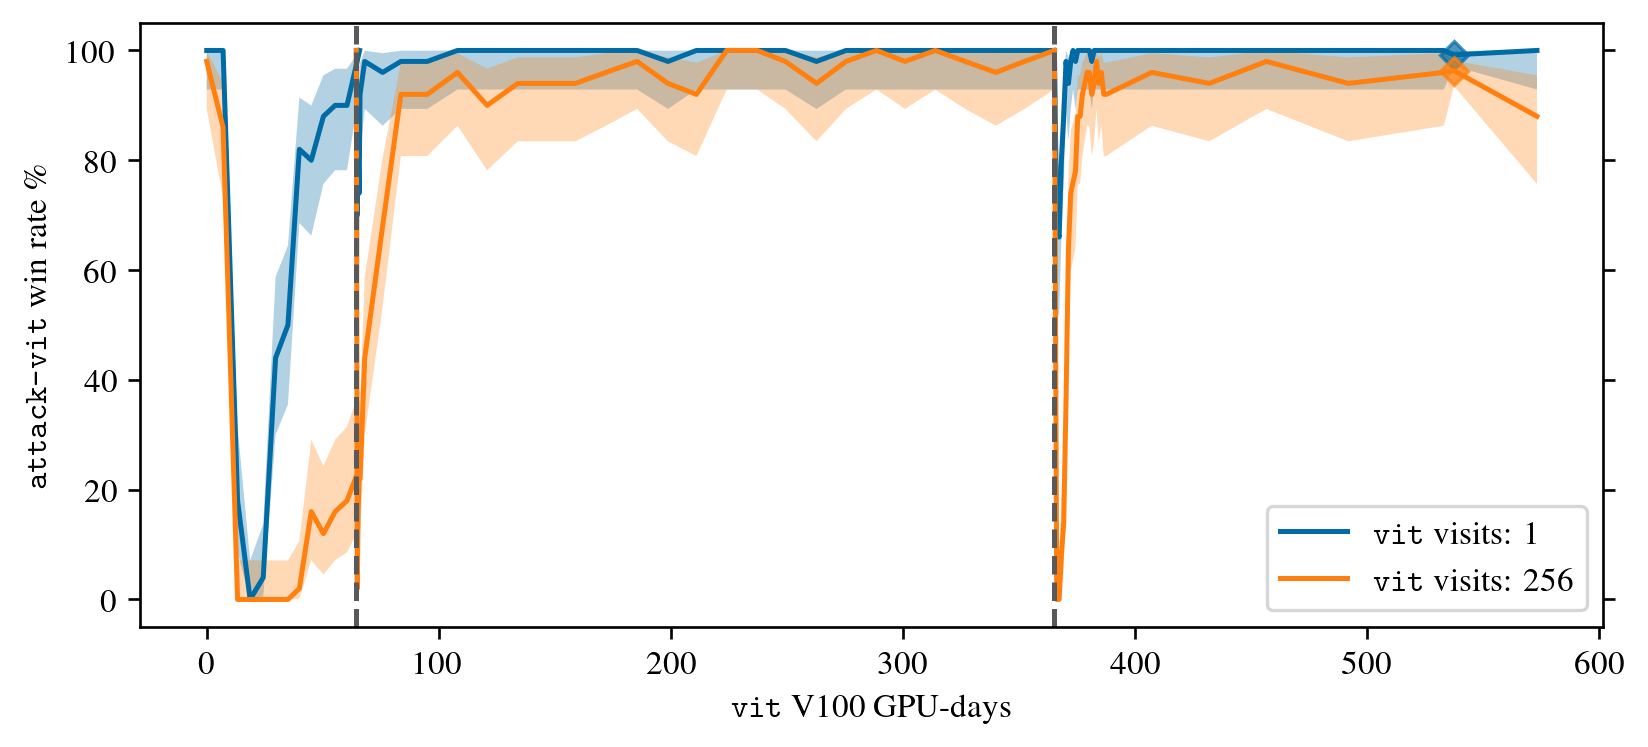

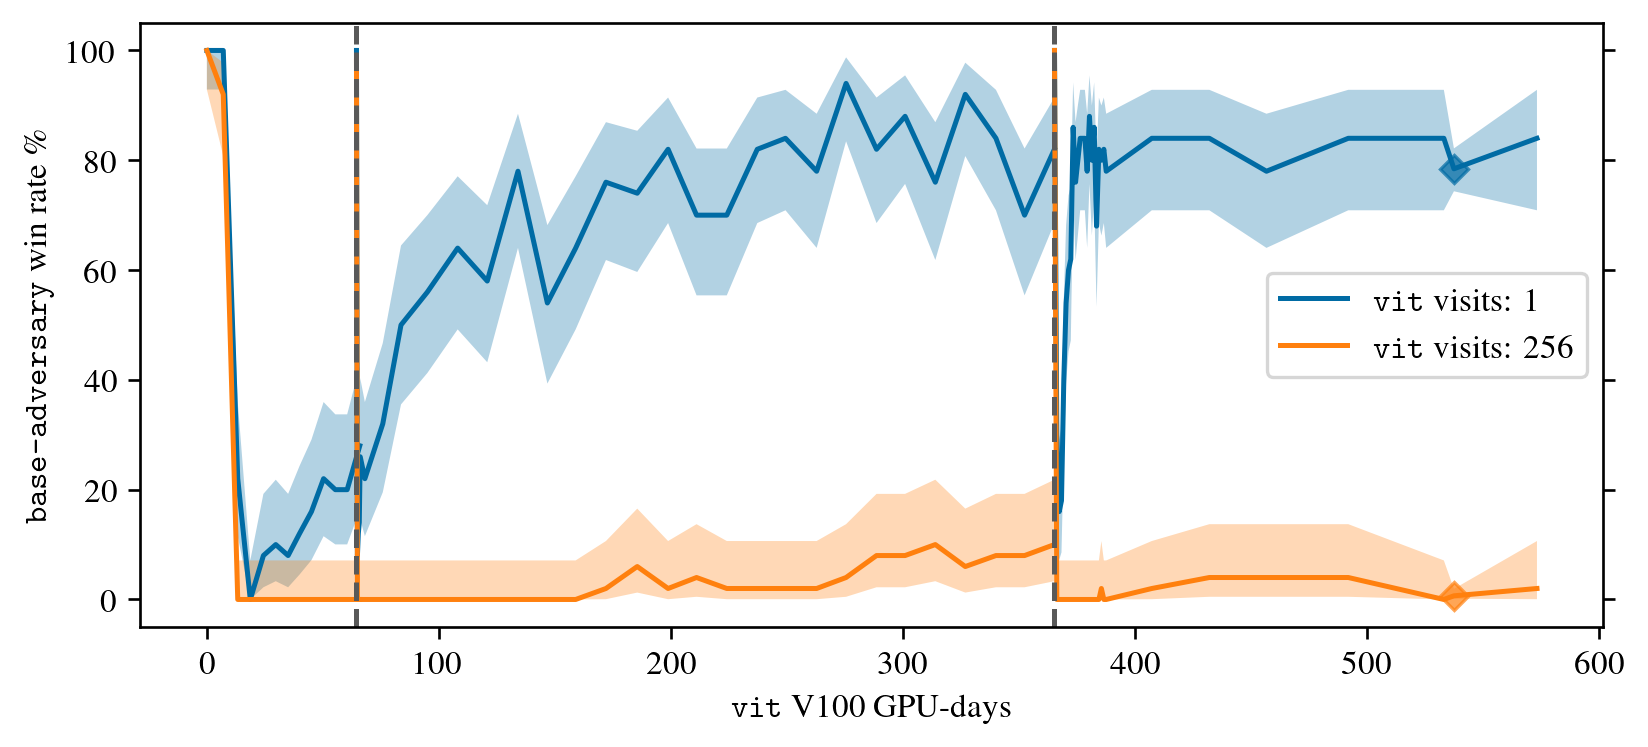

In [78]:
gpu_days_conversions = {
    architecture: cached_get_v100_gpu_days(Path("/shared/victimplay") / path)
    for architecture, path in [
        ("vit-b4", "ttseng-vitp2b4c384-selfplay-231031"),
        ("vit-b8", "ttseng-vitp2b8c384-selfplay-231106"),
        ("vit-b16", "ttseng-vitp2b16c384-minrows10m-240103"),
    ]
}

# All GPU-days need to be scaled down to estimate the cost had we trained with
# FP16 instead of FP32.
# Also, vit-b8 and vit-b16 had a pre-training phase, and vit-b16 warmstarted
# from another pre-training-only preliminary vit-b16 run.
gpu_days_conversions["vit-b4"] = {
    steps: gpu_days * 0.4921424391 + 2.746 * (steps / VIT_B4_MAX_STEPS)
    for (steps, gpu_days) in gpu_days_conversions["vit-b4"].items()
}
gpu_days_conversions["vit-b8"] = {
    steps: gpu_days * 0.4449017465 + 11.627 * (steps / VIT_B8_MAX_STEPS)
    for (steps, gpu_days) in gpu_days_conversions["vit-b8"].items()
}

vit_b16_pre_warmstart_steps_list = utils.get_all_adversary_steps(Path("/shared/victimplay/ttseng-vitp2b16c384-selfplay-231124"))
vit_b16_warmstart_steps = min(gpu_days_conversions["vit-b16"].keys())
gpu_days_conversions["vit-b16"].update({
    steps: 0 
    for steps in vit_b16_pre_warmstart_steps_list
    if steps <= vit_b16_warmstart_steps
})
gpu_days_conversions["vit-b16"] = {
    steps: gpu_days * 0.3364575545 + 27.618 * (steps / VIT_B16_MAX_STEPS)
    for (steps, gpu_days) in gpu_days_conversions["vit-b16"].items()
}

df['victim_gpu_days'] = df.apply(lambda row: gpu_days_conversions[row["victim_architecture"]][row["original_victim_steps"]], axis=1)

vit_b4_gpu_days = gpu_days_conversions["vit-b4"][VIT_B4_MAX_STEPS]
vit_b8_gpu_days = gpu_days_conversions["vit-b8"][VIT_B8_MAX_STEPS]
# Show vit-b4, vit-b8, and vit-b16 sequentially
df.loc[df["victim_architecture"] == "vit-b8", "victim_gpu_days"] += vit_b4_gpu_days
df.loc[df["victim_architecture"] == "vit-b16", "victim_gpu_days"] += vit_b4_gpu_days + vit_b8_gpu_days

for adv_name, adv_label in [
    ("attack-vit-s326m", r"\texttt{attack-vit}"),
    ("cyclic-s545m", r"\texttt{base-adversary}"),
]:
    # Plot different architectures separately so that their lines
    # aren't connected.
    for i, architecture in enumerate(["vit-b4", "vit-b8", "vit-b16"]):
        highlighted_steps = VIT_B4_MAX_STEPS + VIT_B8_MAX_STEPS + 650025472 if architecture == "vit-b16" else None
        generate_fancy_plots(
            df[df["victim_architecture"] == architecture], 
            adv_name=adv_name,
            highlighted_victim_steps=highlighted_steps,
            skip_legend=(i != 0),
            custom_legend_label=r"\texttt{vit} visits: ",
            custom_xlabel=r"\texttt{vit} V100 GPU-days",
            custom_ylabel=f"{adv_label} win rate \%",
            x_axis_column="victim_gpu_days",
        )
    for gpu_days in [ vit_b4_gpu_days, vit_b4_gpu_days + vit_b8_gpu_days ]:
        plt.axvline(x=gpu_days, linestyle="--", color=COLORS[3])
    plt.show()

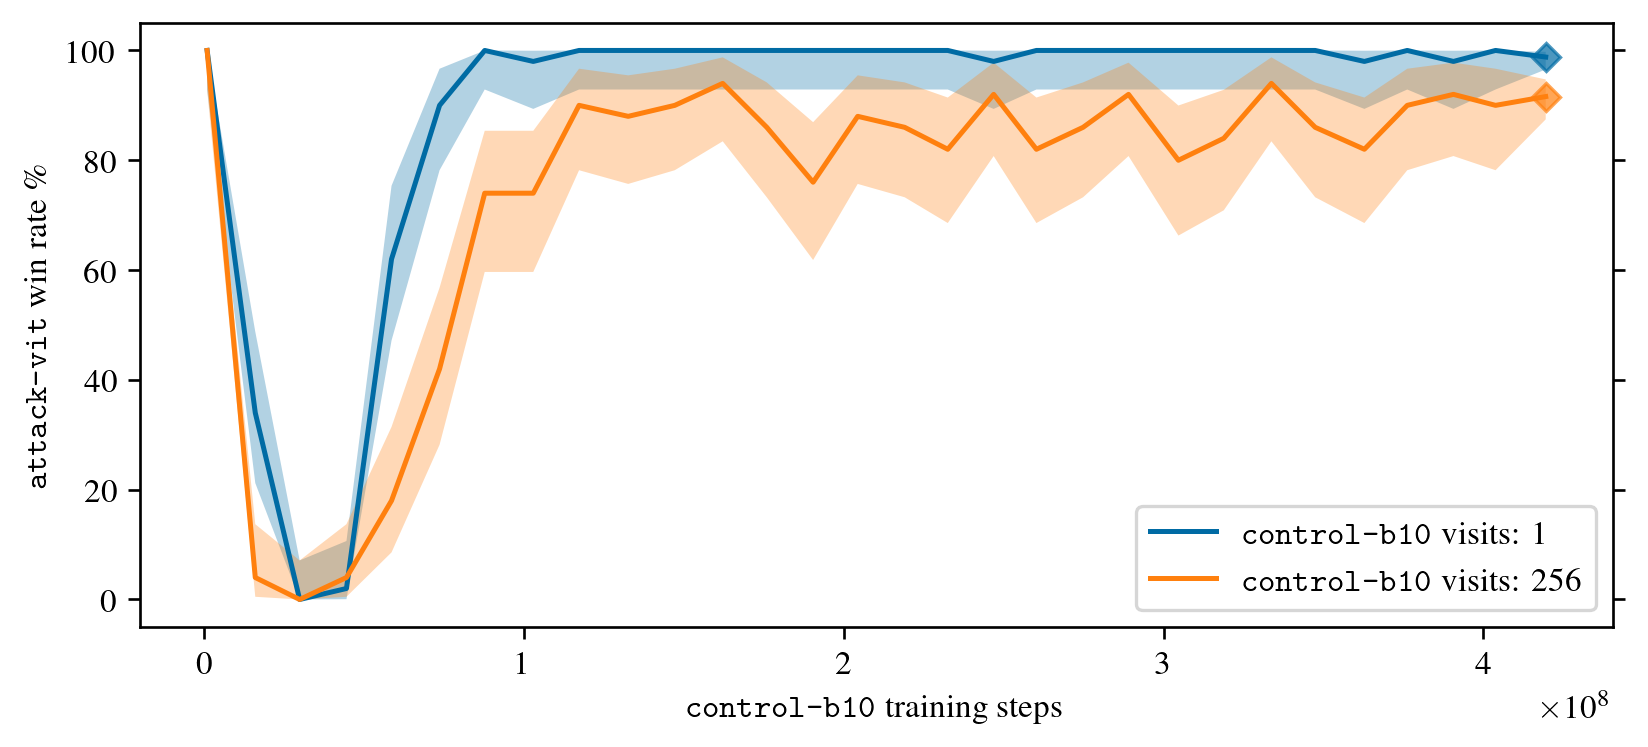

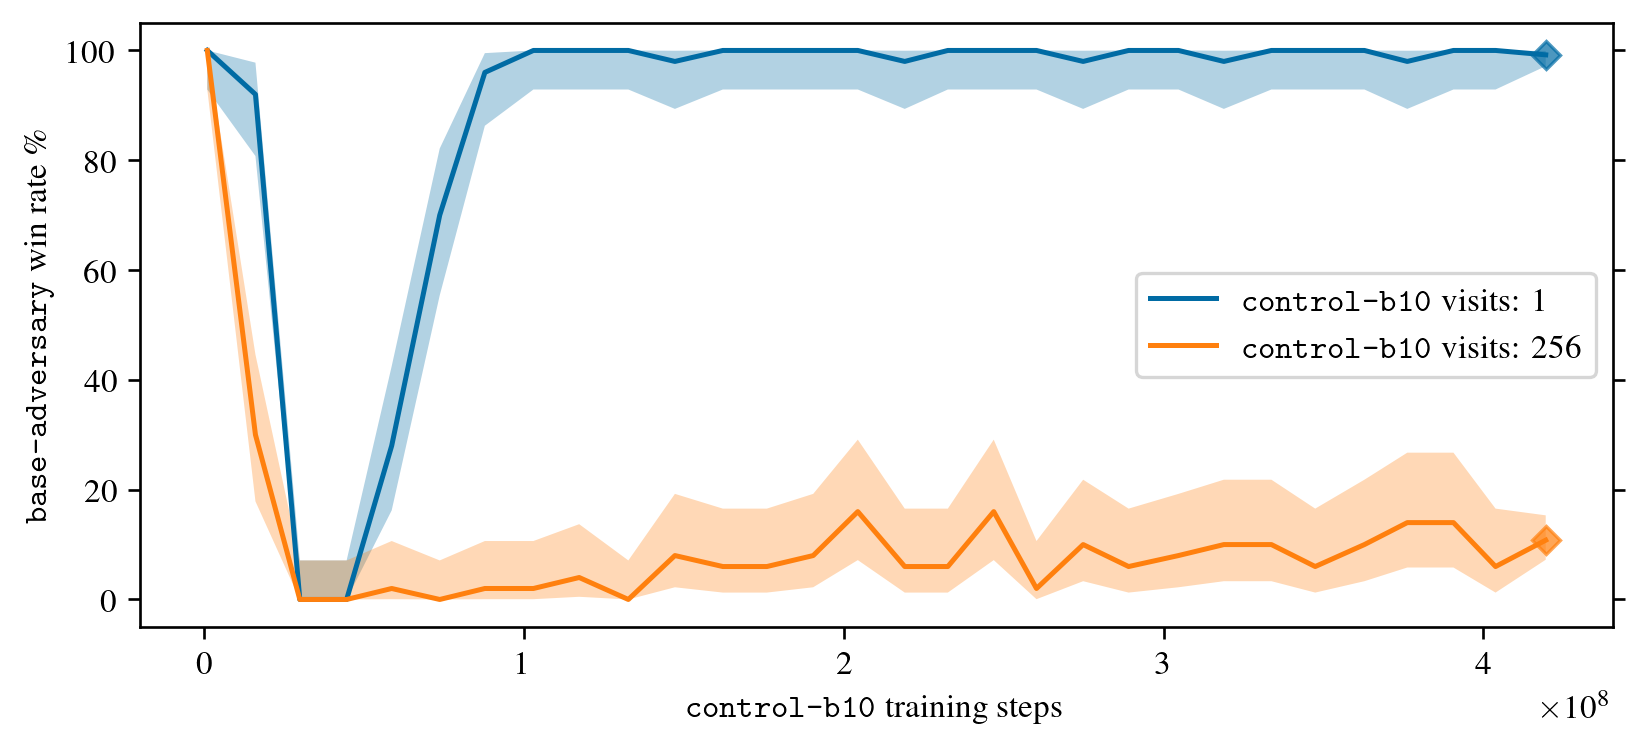

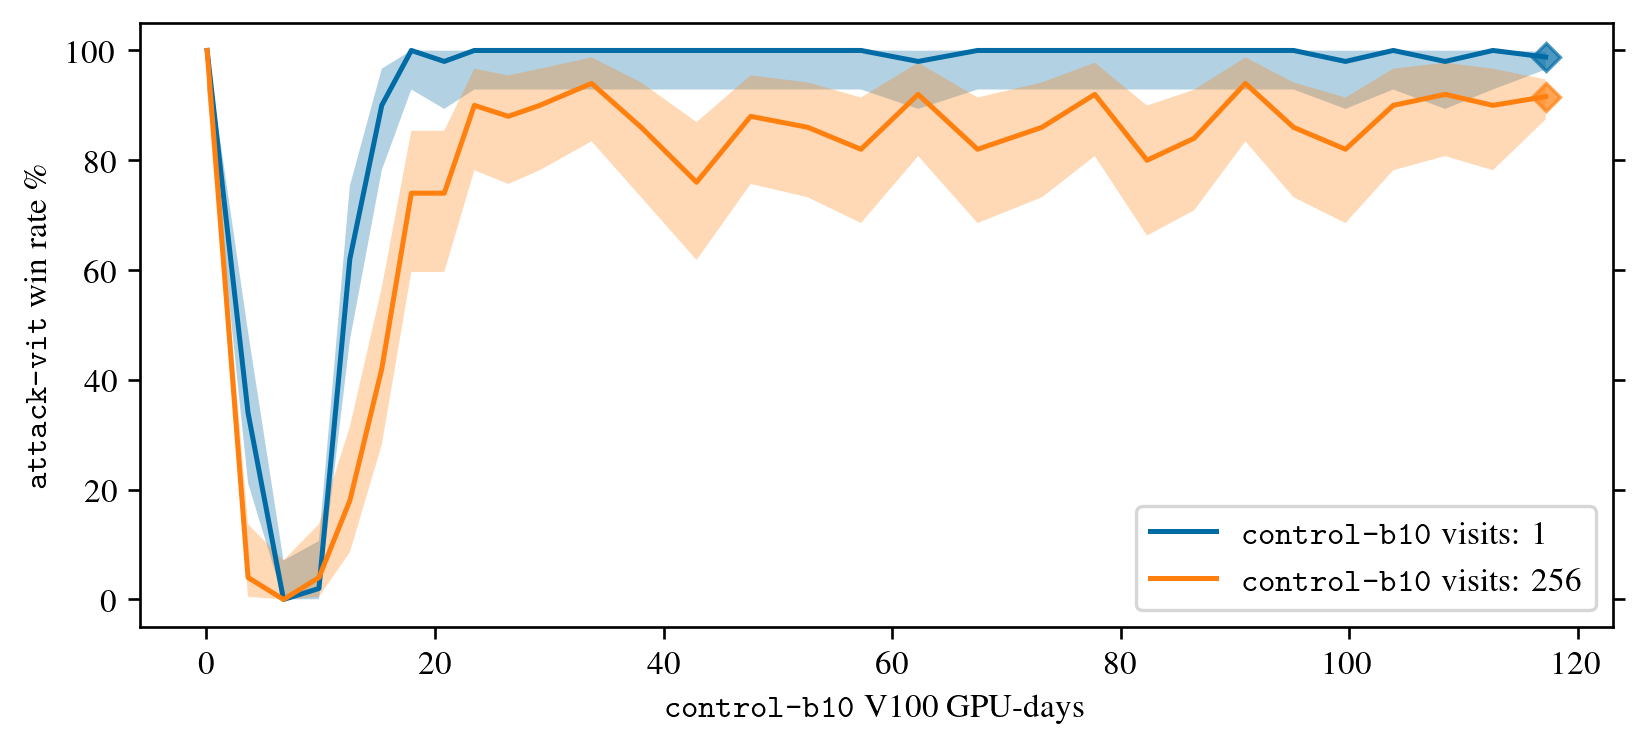

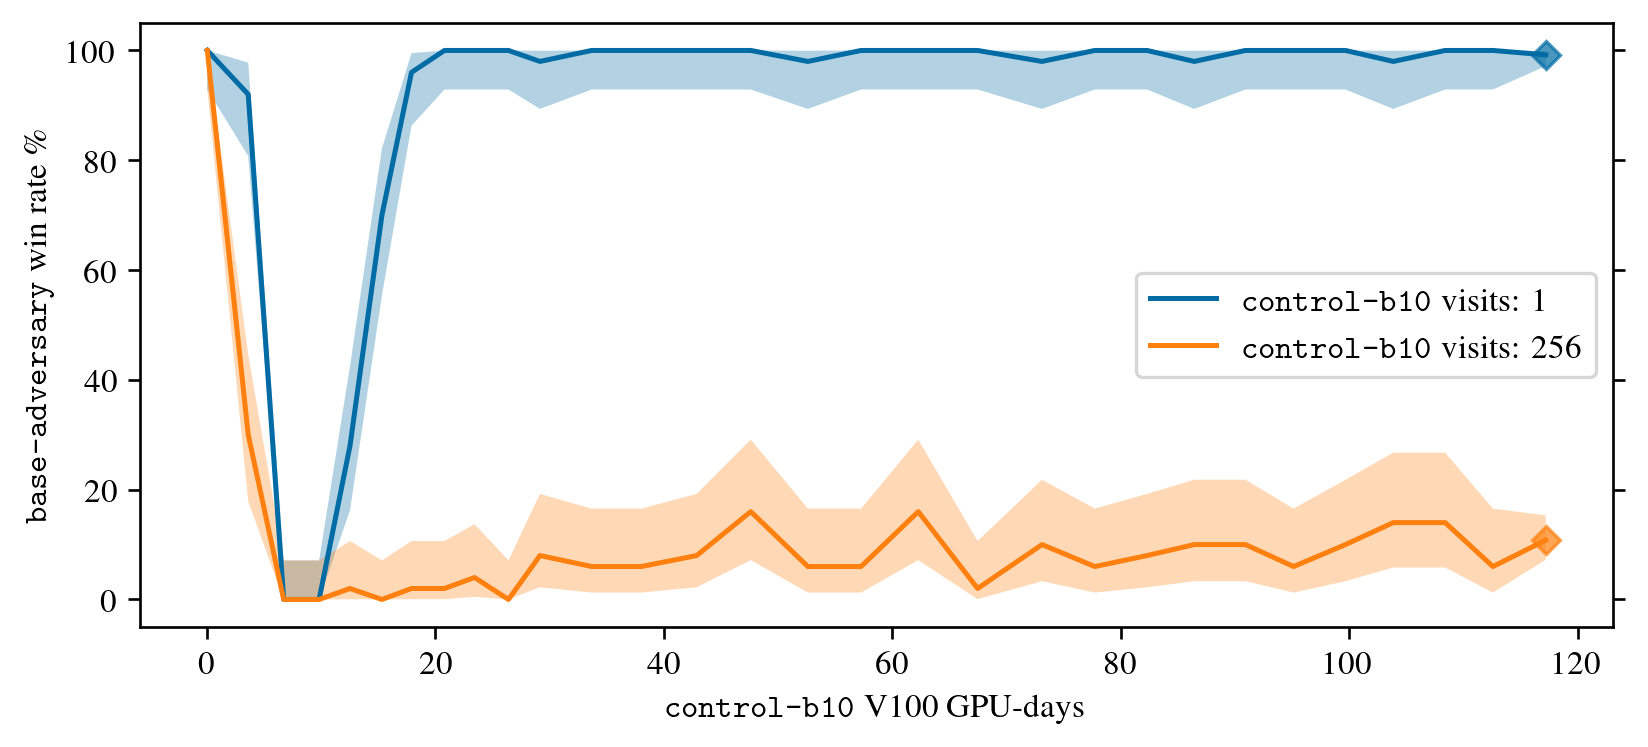

In [79]:
df = utils.parse_sgfs(["/shared/match/ttseng-vit-selfplay-240314/b10"])
swap_adv_and_victim(df)
steps_to_gpu_days = cached_get_v100_gpu_days(Path("/shared/victimplay/ttseng-b10-selfplay-231026"))
df['victim_gpu_days'] = df.apply(lambda row: steps_to_gpu_days[row["victim_steps"]], axis=1)

for x_axis_column, x_label in [
    ("victim_steps", "training steps"),
    ("victim_gpu_days", "V100 GPU-days"),
]:
    for adv_name, adv_label in [
        ("attack-vit-s326m", r"\texttt{attack-vit}"),
        ("cyclic-s545m", r"\texttt{base-adversary}"),
    ]:
        generate_fancy_plots(
            df, 
            adv_name=adv_name,
            highlighted_victim_steps=419465984,
            custom_legend_label=r"\texttt{control-b10} visits: ",
            custom_xlabel=rf"\texttt{{control-b10}} {x_label}",
            custom_ylabel=f"{adv_label} win rate \%",
            x_axis_column=x_axis_column,
        )
        plt.show()